# Simulation of non-radiative capture


In [ ]:
from pathlib import Path
from pymatgen.analysis.defects.ccd import HarmonicDefect, SRHCapture
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
TEST_FILES = Path("../tests/test_files/v_Ga/")

## Read a single Harmonic Defect

We can parse an sorted list of directories with `HarmonicDefect.from_directories`.
This will look into each directory for a `vasprun.xml` file from which the structures and energies will be extracted.

The different constructors for `HarmonicDefect` all accept a list of sources where the energies and structures come from.
The relaxed structure will be taken from the `relaxed_index` entry from this list and the electronic structure from this entry will be parsed to help identify the defect band in the band structure.


In [ ]:
dirs01 = [TEST_FILES / "ccd_0_-1" / str(i) for i in [0,1,2]]
hd0 = HarmonicDefect.from_directories(
    directories=dirs01,
    store_bandstructure=True,
)
print(f"The relaxed structure is in dirs01[{hd0.relaxed_index}]")
print(hd0)
print(f"The spin channel ({hd0.spin}) is also automaticalliy determined by the "
      "IPR, by taking the spin channel with the lowest average IPR.")


The relaxed structure is in dirs01[1]
HarmonicDefect(omega=0.505 eV, charge=0.0, relaxed_index=1, spin=1, defect_band=[(138, 0, 1), (138, 1, 1)])
The spin channel (-1) is also automaticalliy determined by the IPR, by taking the spin channel with the lowest average IPR.


Note that the `defect_band` attribute of `HarmonicDefect` consists of multiple states presented as `(iband, ikpt, ispin)` index tuples, if `defect_band` was not provided to the constructor, the `relaxed_index` entry in the directory list will be checked for a Procar file, which will be parsed to give the "best guess" of the defect state in the band structure.
For simulations with well-defined The band index is automatically determined by the inverse participation ratio.
Note that the defect state reports the "most-localized" bands at each k-point so it is possible for the band index of the defect band to chang for different kpoint indices `ikpt`.


<div class="alert alert-block alert-info"><b>Note:</b> The automated defect state identification is still in testing so you can provide the `defect_band` manually to over-ride the automatic behavior.
</div>


### Potential energy surface

The potential energy surface of the defect in a particular charge state is given by:

$$\frac{1}{2} \omega^2 Q^2$$


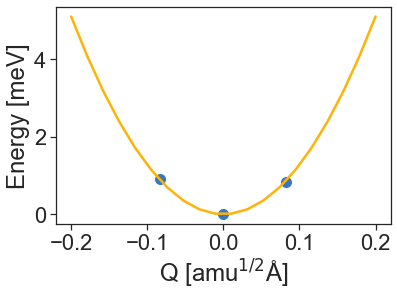

In [ ]:
plt.plot(hd0.distortions, (np.array(hd0.energies) - hd0.energies[hd0.relaxed_index]) * 1000, "o", ms=10)
xx = np.linspace(-0.2, 0.2, 20)
yy = 0.5 * hd0.omega**2 * xx ** 2
plt.plot(xx,yy*1000)
plt.xlabel("Q [amu$^{1/2}$Å]");
plt.ylabel("Energy [meV]");


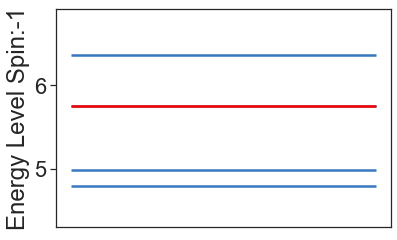

In [ ]:
bs = hd0.relaxed_bandstructure
eigs = bs.bands[hd0.spin][:,1]
eigs_ref_efermi = eigs
plt.hlines([eigs_ref_efermi], 0,1)
plt.hlines(eigs_ref_efermi[hd0.defect_band_index], 0,1, colors="red")
plt.ylim(bs.efermi-0.1,bs.efermi+2.5)
plt.xticks([]);
plt.ylabel(f"Energy Level Spin:{hd0.spin}");


From the eigenvalue file:

```
#   nband        eig (+1)        eig (-1)   occ (+1)   occ (-1)
    138          4.281429        4.983887   0.999759   0.000000
    139          4.341242        5.752503   0.963967   0.000000  <- Defect
    140          6.269717        6.356752   0.000000   0.000000
    141          8.441992        8.536628   0.000000   0.000000
```

## Combined two HarmonicDefects and a series of WSWQ

Read the information required for SRH recombination from directories.

<div class="alert alert-block alert-info"><b>Note:</b> I'm seriously considering changing this to be functional since this feels really over-engineered at this point.
</div>


In [ ]:
srh = SRHCapture.from_directories(
    initial_dirs=[TEST_FILES / "ccd_0_-1" / str(i) for i in [0,1,2]],
    final_dirs=[TEST_FILES / "ccd_-1_0" / str(i) for i in [0,1,2]],
    wswq_dir = TEST_FILES / "ccd_0_-1" / "wswqs",
    store_bandstructure=True,
)


In [ ]:
T = np.linspace(100, 1000, 20)
cc = srh.get_coeff(T, 0.3, kpt_index=1)

In [ ]:
plt.plot(T, cc)